# **IST 736: Text Mining**

**Nikita Ramsey**


Homework #7

# **Introduction:**

For this assignment, I'll be using the movie review sentiment data provided in class to run several different experimental designs for a sentiment classification model. The first task will focus on unigram SVM and Naive Bayes models using a 40% test split, the second task will focus on bi,tri, and quad grams SVM and Naive Bayes models using a 40% test split, and the third task will focus on the finding the best  SVM model using 100% of the training data.



We'll first start by loading in the necessary packages and libraries.

In [ ]:
# Install libraries
!pip install seaborn spacy nltk pandas matplotlib contractions textblob ace_tools 

In [ ]:
# Load packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import contractions
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.pipeline import Pipeline

# **Data:**

This movie review sentiment data was retrieved from a school resource that originally obtainined it from Kaggle. There are 156060 observations and 4 columns in this dataset including:

*  PhraseId
*  SentenceId
*  Phrase
*  Sentiment


The Sentiment column is the predictive column of interest and contains five different labels:

*  0 - negative
*  1 - somewhat negative
*  2 - neutral
*  3 - somewhat positive
*  4 - positive

In [3]:
# Load the data
csv_file = 'train.tsv'
df = pd.read_csv(csv_file, sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [4]:
# Adjust column settings and review the data
pd.set_option('display.max_colwidth', None)
df.head()

PhraseId  SentenceId  \
0         1           1   
1         2           1   
2         3           1   
3         4           1   
4         5           1   

                                                                                                                                                                                         Phrase  \
0  A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .   
1                                                                                                                 A series of escapades demonstrating the adage that what is good for the goose   
2                                                                                                                                                                                      A series   
3                                                                                                                                                                                             A   
4                                                                                                                                                                                        series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2

Due to the size of the dataset, we'll downsample for faster compute and management.

In [5]:
# Randomly sample 15000 rows from the original DataFrame
df = df.sample(n=15000, random_state=42)

In [6]:
# Review the category distribution
df['Sentiment'].value_counts()

Sentiment
2    7511
3    3150
1    2700
4     927
0     712
Name: count, dtype: int64

In [7]:
# View NAs
df.isna().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [8]:
# View duplicates
df.duplicated().sum()

0

In [9]:
# Redefine the dataframe
df = df[['Phrase', 'Sentiment']]
df.head()

Phrase  \
95722                                                                                                              's as sorry   
147312  Romantic comedy and Dogme 95 filmmaking may seem odd bedfellows , but they turn out to be delightfully compatible here   
36991                                                                                                            of these days   
150211                                                                                    flinch from its unsettling prognosis   
140655                                                                                                are clinically depressed   

        Sentiment  
95722           2  
147312          4  
36991           2  
150211          2  
140655          1

**Initial Preprocessing:**

To begin the preprocessing of the text, this function will be used to get the data in a clean state.

In [10]:
# Create function to clean the text
def clean_text(text):
  text = contractions.fix(text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  return text.lower().strip()

In [11]:
"""

# Let's create a function to clean the Phrase column

def data_preprocess(Phrase):
    Phrase = re.sub(re.compile('<.*?>'), '', Phrase) #removing html tags if any
    Phrase =  re.sub('[^A-Za-z0-9]+', ' ', Phrase) #taking only words
    Phrase = Phrase.lower()   # making all phrases lower case
    tokens = nltk.word_tokenize(Phrase) # converts Phrases to tokens
    Phrase = [word for word in tokens if word not in stop_words] #removing stop words
    Phrase = [lemmatizer.lemmatize(word) for word in Phrase]   # lemmatization
    Phrase = ' '.join(Phrase)  # join words in preprocessed Phrase

    return Phrase


"""

"\n\n# Let's create a function to clean the Phrase column\n\ndef data_preprocess(Phrase):\n    Phrase = re.sub(re.compile('<.*?>'), '', Phrase) #removing html tags if any\n    Phrase =  re.sub('[^A-Za-z0-9]+', ' ', Phrase) #taking only words\n    Phrase = Phrase.lower()   # making all phrases lower case\n    tokens = nltk.word_tokenize(Phrase) # converts Phrases to tokens\n    Phrase = [word for word in tokens if word not in stop_words] #removing stop words\n    Phrase = [lemmatizer.lemmatize(word) for word in Phrase]   # lemmatization\n    Phrase = ' '.join(Phrase)  # join words in preprocessed Phrase\n\n    return Phrase\n\n\n"

In [12]:
# Clean the text and add to df
df['Cleaned_Text'] = df['Phrase'].apply(clean_text)

# Compare original text to ensure application
df['Phrase'].head()

95722                                                                                                                's as sorry
147312    Romantic comedy and Dogme 95 filmmaking may seem odd bedfellows , but they turn out to be delightfully compatible here
36991                                                                                                              of these days
150211                                                                                      flinch from its unsettling prognosis
140655                                                                                                  are clinically depressed
Name: Phrase, dtype: object

In [13]:
# Review cleaned text
df['Cleaned_Text'].head()

95722                                                                                                              s as sorry
147312    romantic comedy and dogme  filmmaking may seem odd bedfellows  but they turn out to be delightfully compatible here
36991                                                                                                           of these days
150211                                                                                   flinch from its unsettling prognosis
140655                                                                                               are clinically depressed
Name: Cleaned_Text, dtype: object

**Exploratory Data Analysis**

Here we'll look at the distribution of text lengths, word counts, average word lengths, polarity, and lie and sentiment label distributions, in addition to creating various unigram WordClouds.

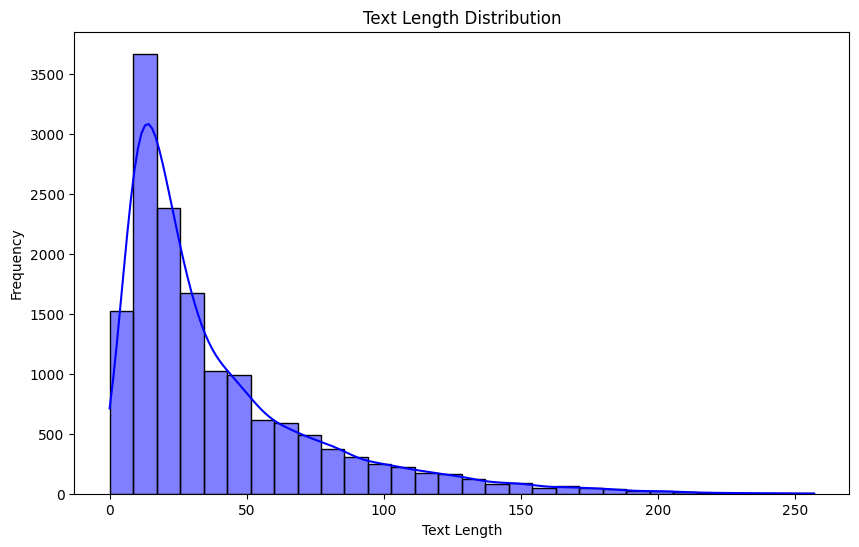

In [15]:
#1. Text length distribution
df['Text_Length'] = df['Cleaned_Text'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(df['Text_Length'], bins=30, kde=True, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

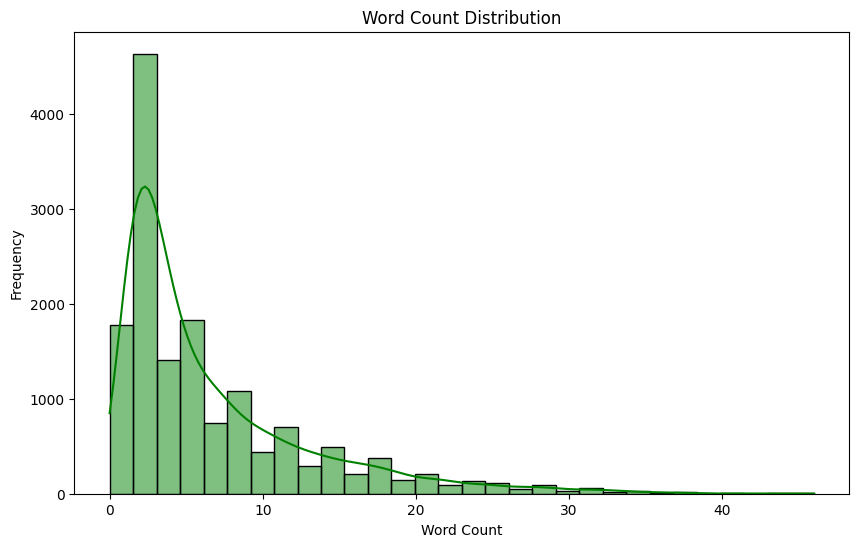

In [16]:
#2. Text word count distribution
df['Word_Count'] = df['Cleaned_Text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(df['Word_Count'], bins=30, kde=True, color='green')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

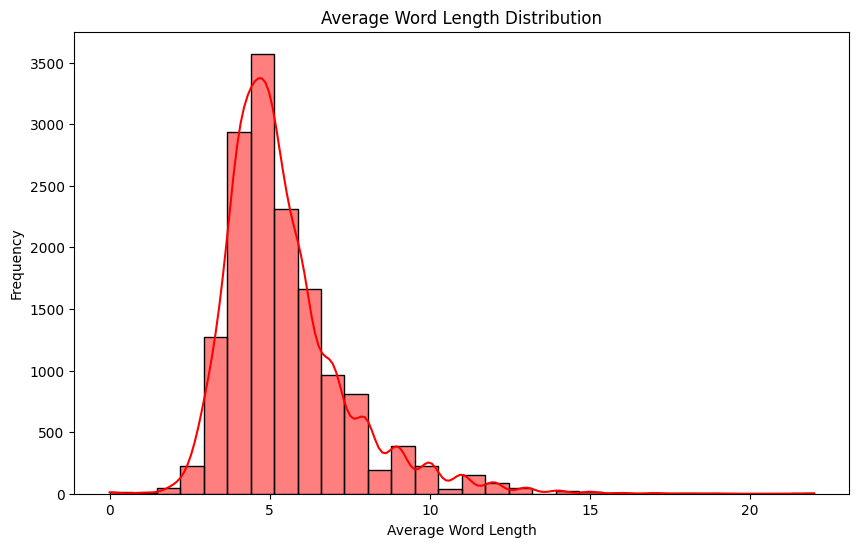

In [17]:
#3. Average word length distribution
df['Avg_Word_Length'] = df['Cleaned_Text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)

plt.figure(figsize=(10,6))
sns.histplot(df['Avg_Word_Length'], bins=30, kde=True, color='red')
plt.title('Average Word Length Distribution')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.show()

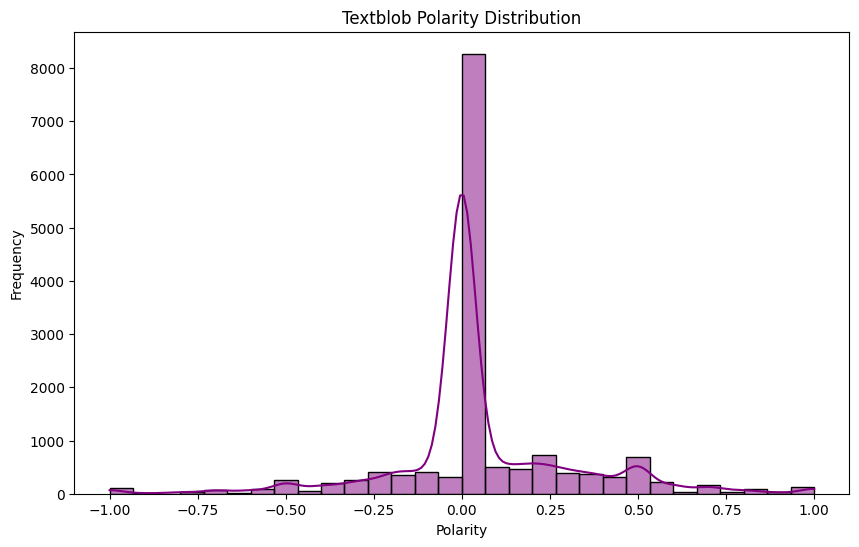

In [18]:
#4. Textblob Polarity distribution
df['Textblob_polarity'] = df['Cleaned_Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10,6))
sns.histplot(df['Textblob_polarity'], bins=30, kde=True, color='purple')
plt.title('Textblob Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

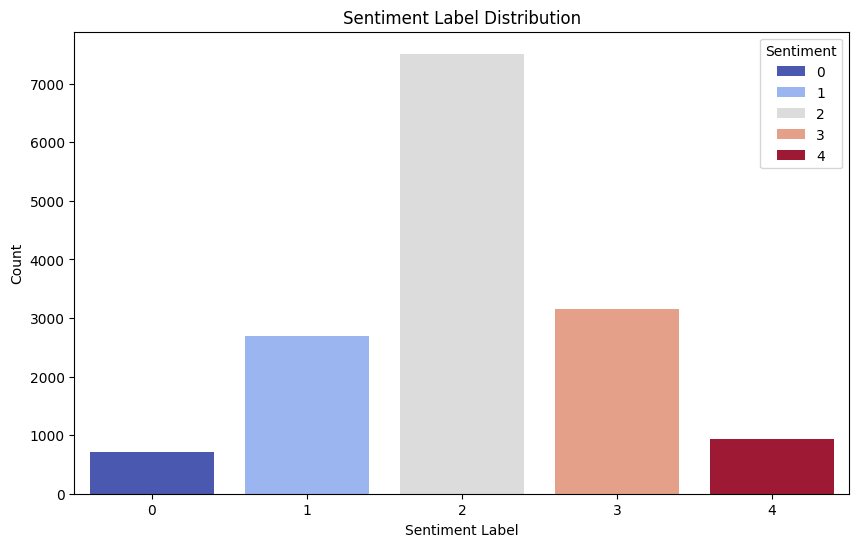

In [19]:
#5. Sentiment Label distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Sentiment', hue='Sentiment', palette='coolwarm')
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

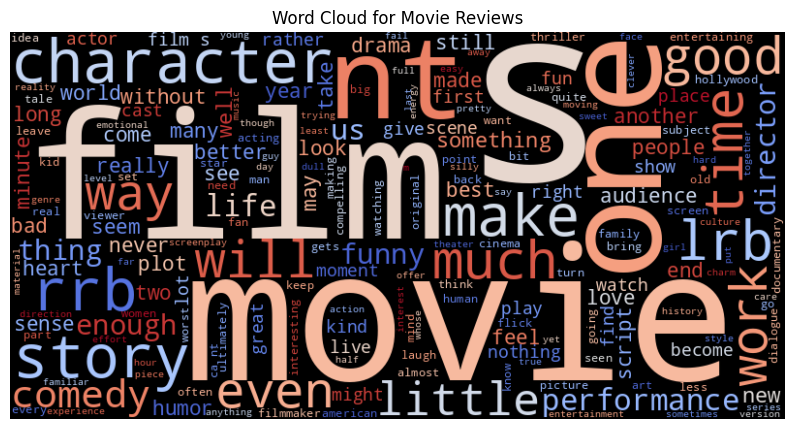

In [20]:
#7. Wordclouds
all_text = ' '.join(df['Cleaned_Text'])
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(all_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Movie Reviews')
plt.show()

In [20]:
# Load spacy for wc preprocessing
nlp = spacy.load('en_core_web_sm')

# Remove "not" and "no" from the stopwords list, if present
print("not" in nlp.Defaults.stop_words)
print("no" in nlp.Defaults.stop_words)

# Set stopword flag to False, which is used by tokens.
lex_not = nlp.vocab["not"]
lex_not.is_stop = False

lex_no = nlp.vocab["no"]
lex_no.is_stop = False

True
True


In [21]:
# Create function to prereprocess text for frequency wordcloud
def preprocess_for_wc(text):
  doc = nlp(text.lower())
  return [token.text for token in doc if not token.is_stop and not token.is_punct]

In [22]:
# Define custom stop words based off initial wordcloud
custom_stops = ["film", "movie", " ", ":", " : ", "s","like", "nt", "story", "bad", "rrb", "lrb", "characters"]

In [23]:
# Apply preprocessing function
df['WC_Processed_Text'] = df['Cleaned_Text'].apply(preprocess_for_wc)
word_freq = Counter([token for tokens in df['WC_Processed_Text'] for token in tokens])
word_freq

Counter({'s': 1664,
         'sorry': 3,
         'romantic': 55,
         'comedy': 177,
         'dogme': 4,
         ' ': 4591,
         'filmmaking': 31,
         'odd': 26,
         'bedfellows': 2,
         'turn': 28,
         'delightfully': 10,
         'compatible': 1,
         'days': 18,
         'flinch': 2,
         'unsettling': 24,
         'prognosis': 3,
         'clinically': 1,
         'depressed': 2,
         'silly': 36,
         'sophomoric': 9,
         'ensnare': 1,
         'target': 18,
         'audience': 86,
         'thoughtful': 19,
         'having': 14,
         'dramatic': 34,
         'impact': 14,
         'manage': 4,
         'spectacularly': 4,
         'outrageous': 11,
         'hunk': 2,
         'forgotten': 13,
         'minutes': 71,
         'slapstick': 14,
         'labored': 4,
         'bigger': 7,
         'setpieces': 2,
         'flat': 28,
         'fusty': 2,
         'disguise': 6,
         'fact': 18,
         'new': 138,
     

In [24]:
# Sort word frequencies from greatest to least
sorted_word_freq = word_freq.most_common()
for word, freq in sorted_word_freq:
    print(f"{word}: {freq}")

 : 4591
s: 1664
film: 646
movie: 614
nt: 368
not: 349
like: 321
story: 271
rrb: 230
lrb: 193
good: 190
comedy: 177
characters: 177
no: 173
time: 172
little: 162
way: 143
love: 139
new: 138
life: 133
bad: 128
funny: 128
work: 121
action: 118
director: 116
movies: 116
best: 111
people: 109
drama: 105
world: 99
films: 96
plot: 94
better: 88
audience: 86
makes: 86
performances: 85
  : 84
character: 84
long: 82
humor: 80
hollywood: 79
big: 76
sense: 76
seen: 74
script: 74
performance: 72
minutes: 71
look: 71
great: 71
human: 70
feel: 69
family: 69
man: 68
watching: 68
heart: 68
cast: 67
fun: 66
real: 66
young: 66
things: 65
acting: 65
tale: 65
screen: 65
moments: 63
right: 63
kind: 62
old: 62
thing: 61
watch: 61
entertaining: 60
american: 60
end: 60
come: 59
ve: 59
thriller: 59
times: 58
lot: 57
emotional: 56
hard: 56
romantic: 55
year: 54
making: 54
actors: 54
interesting: 54
dialogue: 54
art: 53
going: 53
original: 53
pretty: 52
far: 52
find: 51
scenes: 51
women: 51
ultimately: 51
cinema:

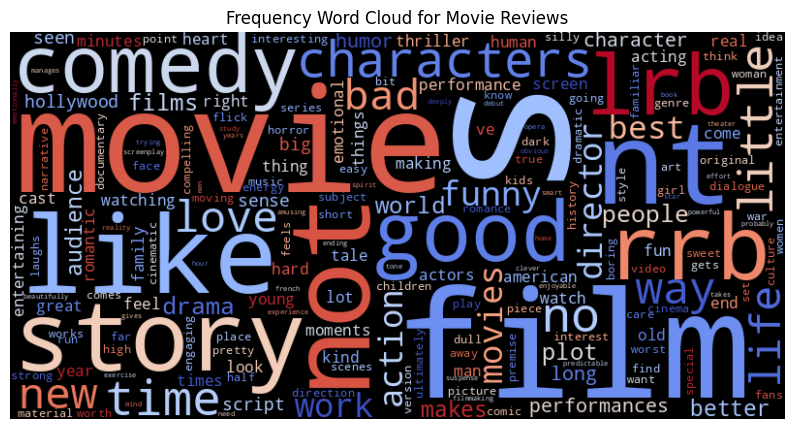

In [25]:
#8. Wordcloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate_from_frequencies(word_freq)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequency Word Cloud for Movie Reviews')
plt.show()

In [26]:
# Create groupings for negative, neutral and positive review wordclouds
neg_reviews_tokens = df[df['Sentiment']==0]['WC_Processed_Text']
neg_reviews_flat = [token for tokens in neg_reviews_tokens for token in tokens]
neg_reviews_freq = Counter(neg_reviews_flat)

sorted_neg_reviews_freq = neg_reviews_freq.most_common()
for word, freq in sorted_neg_reviews_freq:
  print(f'{word}: {freq}')

 : 499
s: 111
movie: 82
film: 45
bad: 45
like: 41
nt: 34
not: 26
no: 26
worst: 22
comedy: 22
story: 21
minutes: 19
time: 19
dull: 18
rrb: 16
action: 15
lrb: 14
good: 14
acting: 14
run: 13
mess: 12
audience: 12
  : 12
characters: 12
ugly: 12
script: 12
worse: 11
boring: 11
way: 11
dialogue: 11
flat: 10
direction: 10
plot: 10
feel: 10
stupid: 10
watching: 10
little: 10
hours: 9
tired: 9
fails: 9
half: 9
hollywood: 9
making: 8
completely: 8
unfocused: 8
feels: 8
dumb: 8
thing: 8
poor: 8
times: 8
long: 8
new: 7
director: 7
hard: 7
trying: 7
year: 7
picture: 7
horrible: 7
predictable: 7
lacking: 7
tedious: 7
work: 7
awful: 7
silly: 7
look: 7
makes: 7
runs: 7
horror: 7
ridiculous: 6
cheesy: 6
meandering: 6
ending: 6
films: 6
humor: 6
going: 6
terrible: 6
sad: 6
doze: 6
years: 6
want: 6
theater: 6
flimsy: 6
idea: 6
end: 6
reason: 6
plain: 6
drama: 6
case: 6
sense: 6
care: 6
death: 6
cheap: 6
intelligence: 6
minute: 6
cast: 6
far: 6
tries: 5
backdrops: 5
unfunny: 5
pointless: 5
holes: 5
obviou

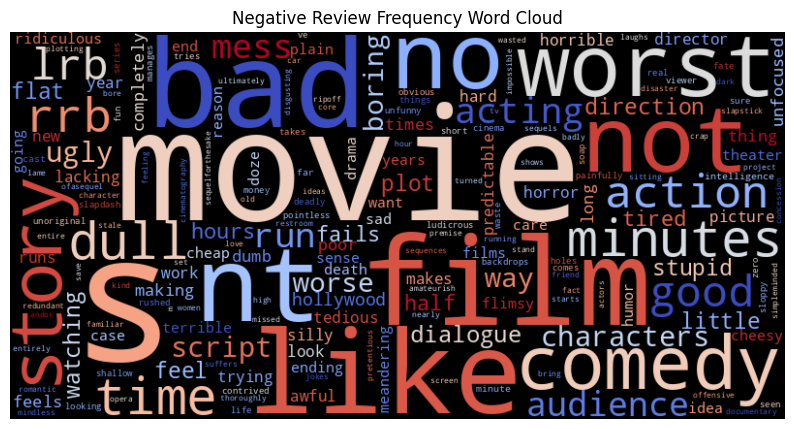

In [27]:
#8. Wordcloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate_from_frequencies(neg_reviews_freq)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Review Frequency Word Cloud')
plt.show()

In [28]:
neut_reviews_tokens = df[df['Sentiment']==2]['WC_Processed_Text']
neut_reviews_flat = [token for tokens in neut_reviews_tokens for token in tokens]
neut_reviews_freq = Counter(neut_reviews_flat)

# Sort word frequencies from greatest to least
sorted_neut_reviews_freq = neut_reviews_freq.most_common()
for word, freq in sorted_neut_reviews_freq:
  print(f'{word}: {freq}')

 : 1326
s: 663
film: 203
movie: 192
not: 123
nt: 108
like: 103
story: 92
rrb: 91
time: 72
lrb: 69
characters: 62
new: 59
director: 54
little: 54
love: 53
life: 52
movies: 51
comedy: 51
way: 50
action: 49
people: 49
no: 45
films: 44
good: 44
world: 44
work: 37
better: 37
character: 37
young: 37
plot: 34
big: 34
long: 32
family: 32
bad: 31
things: 31
war: 30
thing: 29
old: 29
drama: 29
audience: 28
human: 28
seen: 28
man: 28
hollywood: 28
minutes: 27
american: 26
women: 25
look: 25
screen: 25
video: 24
end: 24
funny: 24
times: 23
right: 23
come: 23
lot: 22
art: 22
music: 21
watching: 21
fans: 21
humor: 21
script: 21
best: 20
think: 20
ve: 20
original: 20
emotional: 20
away: 20
tale: 20
interest: 20
going: 19
feel: 19
watch: 19
find: 19
heart: 19
cinema: 19
performance: 19
debut: 19
moments: 19
woman: 19
reality: 18
history: 18
dark: 18
making: 18
material: 18
true: 18
line: 18
subject: 18
  : 18
sense: 18
set: 18
book: 17
men: 17
easy: 17
culture: 17
french: 17
far: 17
kind: 17
scenes: 1

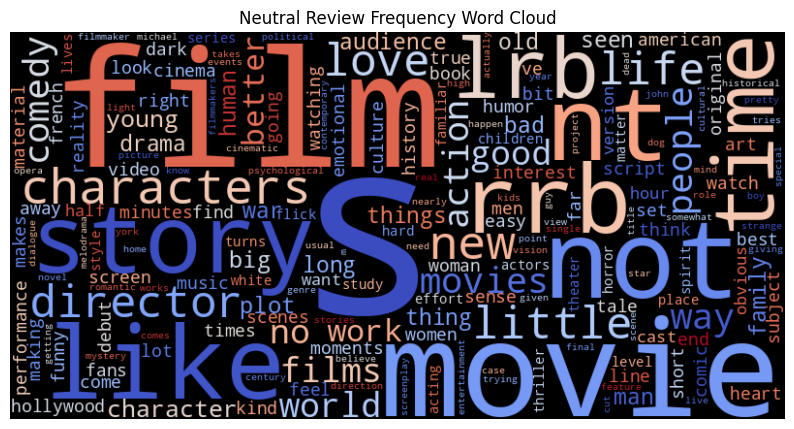

In [29]:
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate_from_frequencies(neut_reviews_freq)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Review Frequency Word Cloud')
plt.show()

In [30]:
pos_reviews_tokens = df[df['Sentiment']==4]['WC_Processed_Text']
pos_reviews_flat = [token for tokens in pos_reviews_tokens for token in tokens]
pos_reviews_freq = Counter(pos_reviews_flat)

# Sort word frequencies from greatest to least
sorted_pos_reviews_freq = pos_reviews_freq.most_common()
for word, freq in sorted_pos_reviews_freq:
  print(f'{word}: {freq}')

 : 541
s: 141
film: 95
movie: 65
best: 37
funny: 34
good: 32
performances: 27
comedy: 25
performance: 25
love: 24
work: 23
story: 22
great: 21
life: 20
entertaining: 19
heart: 18
time: 18
movies: 18
fun: 17
year: 17
cast: 16
new: 16
beautifully: 16
moving: 15
rrb: 15
humor: 15
not: 15
big: 14
lrb: 14
characters: 13
seen: 13
thriller: 13
delightful: 12
touching: 12
powerful: 12
makes: 12
drama: 12
filmmaking: 11
solid: 11
family: 11
engaging: 11
tale: 10
comic: 10
films: 10
beautiful: 10
documentary: 10
exciting: 10
away: 10
screen: 10
acting: 10
brilliant: 10
enjoyable: 9
like: 9
ve: 9
fascinating: 9
nt: 9
gorgeous: 9
remarkable: 9
ensemble: 9
perfect: 9
people: 9
actors: 9
hilarious: 9
sweet: 9
truly: 9
cinema: 9
world: 9
smart: 9
right: 9
way: 9
summer: 8
sense: 8
creative: 8
cinematic: 8
experience: 8
extraordinary: 8
man: 8
human: 8
clever: 8
satisfying: 8
little: 8
action: 8
delightfully: 7
emotional: 7
emotionally: 7
fine: 7
genre: 7
rare: 7
director: 7
picture: 7
surprisingly: 7

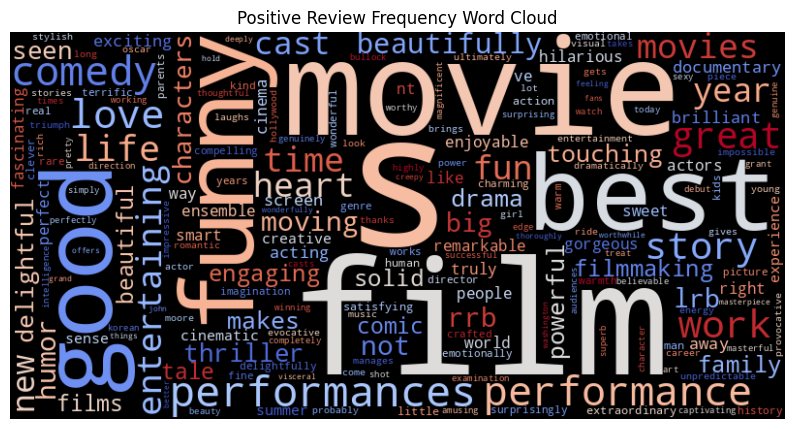

In [31]:
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate_from_frequencies(pos_reviews_freq)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Review Frequency Word Cloud')
plt.show()

# **Methods and Models**

To address this classification problem, Multinomial Naive Bayes will be used to predict the sentiment and lie labels for the food review data.



**Multinomial Naive Bayes (MultinomialNB):**



MultinomialNB is a probabilistic classifier that uses Bayes' theorem to predict class membership. It assumes that the features (e.g., words or n-grams) are conditionally independent given the class label. This model is particularly effective for text classification tasks where word frequency is important.


**Support Vector Machines (SVM):**


Support Vector Machine (SVM) is a supervised machine learning algorithm commonly used for classification tasks. SVM works by finding the optimal hyperplane that best separates data points belonging to different classes. This hyperplane is chosen to maximize the margin, which is the distance between the hyperplane and the closest data points from each class, known as support vectors.

**Experimental Design**

After completing EDA, we'll now lemmatize the text, then create multiple vectorizers utilizing various parameters. From there, we'll pass the vectorized text to MNB and BNB to train the model for prediction.

In [33]:
# Review dataframe
df.head()

Phrase  \
95722                                                                                                              's as sorry   
147312  Romantic comedy and Dogme 95 filmmaking may seem odd bedfellows , but they turn out to be delightfully compatible here   
36991                                                                                                            of these days   
150211                                                                                    flinch from its unsettling prognosis   
140655                                                                                                are clinically depressed   

        Sentiment  \
95722           2   
147312          4   
36991           2   
150211          2   
140655          1   

                                                                                                               Cleaned_Text  \
95722                                                                                                            s as sorry   
147312  romantic comedy and dogme  filmmaking may seem odd bedfellows  but they turn out to be delightfully compatible here   
36991                                                                                                         of these days   
150211                                                                                 flinch from its unsettling prognosis   
140655                                                                                             are clinically depressed   

        Text_Length  Word_Count  Avg_Word_Length  Textblob_polarity  \
95722            10           3         2.666667          -0.500000   
147312          115          18         5.333333           0.277778   
36991            13           3         3.666667           0.000000   
150211           36           5         6.400000          -0.500000   
140655           24           3         7.333333           0.000000   

                                                                                   WC_Processed_Text  
95722                                                                                     [s, sorry]  
147312  [romantic, comedy, dogme,  , filmmaking, odd, bedfellows,  , turn, delightfully, compatible]  
36991                                                                                         [days]  
150211                                                               [flinch, unsettling, prognosis]  
140655                                                                       [clinically, depressed]

In [34]:
# Create function to lemmatize text
def preprocess_text_for_vectorizer(text):
  doc = nlp(text)
  lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
  return ' '.join(lemmas)

In [35]:
# Add lematized text to df
df['Lemmatized_Text'] = df['Cleaned_Text'].apply(preprocess_text_for_vectorizer)

In [36]:
# Compare cleaned text with lemmatized text to ensure application
df[['Cleaned_Text', 'Lemmatized_Text']].head()

Cleaned_Text  \
95722                                                                                                            s as sorry   
147312  romantic comedy and dogme  filmmaking may seem odd bedfellows  but they turn out to be delightfully compatible here   
36991                                                                                                         of these days   
150211                                                                                 flinch from its unsettling prognosis   
140655                                                                                             are clinically depressed   

                                                                      Lemmatized_Text  
95722                                                                         s sorry  
147312  romantic comedy dogme   filmmake odd bedfellow   turn delightfully compatible  
36991                                                                             day  
150211                                                    flinch unsettling prognosis  
140655                                                           clinically depressed

In [37]:
# Review nltk stop words
nltk.download('stopwords')
nltk_stop_words = list(stopwords.words('english'))
nltk_stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [38]:
# Review sklearn stop words
sk_stop_words = list(ENGLISH_STOP_WORDS)
sk_stop_words

['above',
 'bottom',
 'up',
 'four',
 'something',
 'almost',
 'hasnt',
 'mine',
 'how',
 'most',
 'seem',
 'both',
 'they',
 'onto',
 'could',
 'more',
 'everyone',
 'therein',
 'everything',
 'is',
 'interest',
 'before',
 'if',
 'namely',
 'anywhere',
 'name',
 'myself',
 'serious',
 'due',
 'move',
 'empty',
 'too',
 'here',
 'should',
 'once',
 'until',
 'only',
 'detail',
 'ever',
 'anyway',
 'noone',
 'either',
 'am',
 'be',
 'latter',
 'etc',
 'him',
 'as',
 'of',
 'ie',
 'thereby',
 'at',
 'became',
 'then',
 'hundred',
 'within',
 'three',
 'our',
 'any',
 'cry',
 'two',
 'becoming',
 'become',
 'while',
 'whereas',
 'in',
 'eg',
 'themselves',
 'but',
 'have',
 'fill',
 'why',
 'others',
 'whence',
 'whereby',
 'somehow',
 'that',
 'his',
 'upon',
 'first',
 'whether',
 'hers',
 'five',
 'has',
 'are',
 'system',
 'call',
 'down',
 'done',
 'a',
 'much',
 'my',
 'amount',
 'please',
 'below',
 'front',
 'amongst',
 'yours',
 'together',
 'whose',
 'fire',
 'over',
 'there',


In [40]:
# Review dataframe
df.head()

Phrase  \
95722                                                                                                              's as sorry   
147312  Romantic comedy and Dogme 95 filmmaking may seem odd bedfellows , but they turn out to be delightfully compatible here   
36991                                                                                                            of these days   
150211                                                                                    flinch from its unsettling prognosis   
140655                                                                                                are clinically depressed   

        Sentiment  \
95722           2   
147312          4   
36991           2   
150211          2   
140655          1   

                                                                                                               Cleaned_Text  \
95722                                                                                                            s as sorry   
147312  romantic comedy and dogme  filmmaking may seem odd bedfellows  but they turn out to be delightfully compatible here   
36991                                                                                                         of these days   
150211                                                                                 flinch from its unsettling prognosis   
140655                                                                                             are clinically depressed   

        Text_Length  Word_Count  Avg_Word_Length  Textblob_polarity  \
95722            10           3         2.666667          -0.500000   
147312          115          18         5.333333           0.277778   
36991            13           3         3.666667           0.000000   
150211           36           5         6.400000          -0.500000   
140655           24           3         7.333333           0.000000   

                                                                                   WC_Processed_Text  \
95722                                                                                     [s, sorry]   
147312  [romantic, comedy, dogme,  , filmmaking, odd, bedfellows,  , turn, delightfully, compatible]   
36991                                                                                         [days]   
150211                                                               [flinch, unsettling, prognosis]   
140655                                                                       [clinically, depressed]   

                                                                      Lemmatized_Text  
95722                                                                         s sorry  
147312  romantic comedy dogme   filmmake odd bedfellow   turn delightfully compatible  
36991                                                                             day  
150211                                                    flinch unsettling prognosis  
140655                                                           clinically depressed

Divide the data so there's a training and text set for both preiction models

In [41]:
# Randomly sample 2500 rows from the original DataFrame
df_sample = df.sample(n=2500, random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_sample['Lemmatized_Text'], df_sample['Sentiment'], test_size=0.4, random_state=42, stratify=df_sample['Sentiment'])

# Display the splits
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1500
Test set size: 1000


In [42]:
# Review the label distribution of the sample
y_train.value_counts()

Sentiment
2    753
3    319
1    254
4     98
0     76
Name: count, dtype: int64

After several iterations of testing, will manually undersample to see if that improves model performance.

In [43]:
# Will try undersampling to help improve performance
from sklearn.utils import resample

# Combine the training data into one DataFrame
train_data = pd.DataFrame({
    'text': X_train,
    'sentiment': y_train
})

# Separate the classes
df_class0 = train_data[train_data['sentiment'] == 0]
df_class1 = train_data[train_data['sentiment'] == 1]
df_class2 = train_data[train_data['sentiment'] == 2]
df_class3 = train_data[train_data['sentiment'] == 3]
df_class4 = train_data[train_data['sentiment'] == 4]

In [44]:
# Determine the minimum class size (undersampling)
min_size = min(len(df_class0), len(df_class1), len(df_class2), len(df_class3), len(df_class4))

# Undersample each class to the minimum size
df_class0_bal = resample(df_class0, replace=False, n_samples=min_size, random_state=42)
df_class1_bal = resample(df_class1, replace=False, n_samples=min_size, random_state=42)
df_class2_bal = resample(df_class2, replace=False, n_samples=min_size, random_state=42)
df_class3_bal = resample(df_class3, replace=False, n_samples=min_size, random_state=42)
df_class4_bal = resample(df_class4, replace=False, n_samples=min_size, random_state=42)

# Combine the undersampled classes into a balanced training set
balanced_train_data = pd.concat([df_class0_bal, df_class1_bal, df_class2_bal, df_class3_bal, df_class4_bal])

# Split back into X and y
X_train = balanced_train_data['text']
y_train = balanced_train_data['sentiment']

print("Balanced class distribution:")
print(y_train.value_counts())

Balanced class distribution:
sentiment
0    76
1    76
2    76
3    76
4    76
Name: count, dtype: int64


Initialize vectorizers:

Here I'll be trying out different experimental designs for the Count and TFIDF vectorizers. Using different implementations of stop words and ngrams will help to identify which has the strongest impact on model performance for this dataset.


*   Base binary implementation (no parms set)
*   Base base count implementation w/ min_df=2
*   Base base count implementation w/ min_df=2 and custom stop words
*   Base tfidf implementation (no parms set)
*   Base tfidf implementation w/ min_df=2
*   Base tfidf implementation w/ SK Stops and min_df=2
*   Base tfidf implementation w/ custom Stops and min_df=2
<br><br>
*   Base base count implementation w/ Ngrams (2,3)
*   Base base count implementation w/ Ngrams (2,4)
*   Base tfidf implementation w/ Ngrams (2,3)
*   Base tfidf implementation w/ Ngrams (2,4)

In [45]:
# Create vectorizers
vectorizers = {
    # CountVectorizers
    'Base Binary Count': CountVectorizer(binary=True),
    'Base Count Stops': CountVectorizer(min_df=2),
    'Base Custom Stops': CountVectorizer(min_df=2, stop_words=custom_stops),
    #'Base Custom Stops': CountVectorizer(stop_words=custom_stop_words),

    # Define separate vectorizers for different n-gram ranges
    #'Base N-Grams (1,3)': CountVectorizer(ngram_range=(1,3)),
    'Base N-Grams (2,3)': CountVectorizer(ngram_range=(2,3)),
    'Base N-Grams (2,4)': CountVectorizer(ngram_range=(2,4)),

    # TF-IDFs
    'Base TF-IDF No Parms': TfidfVectorizer(),
    'Base TF-IDF': TfidfVectorizer(min_df=2 ),
    'TF-IDF Sklearn Stops': TfidfVectorizer(min_df=2, stop_words=sk_stop_words),
    'TF-IDF Custom Stops': TfidfVectorizer(min_df=2,stop_words=custom_stops),
    #'TF-IDF Custom Stops': TfidfVectorizer(stop_words=custom_stop_words),

    # Define separate vectorizers for different TF-IDF n-gram ranges
    #'TF-IDF N-Grams (1,3)': TfidfVectorizer(ngram_range=(1,3)),
    'TF-IDF N-Grams (2,3)': TfidfVectorizer(ngram_range=(2,3)),
    'TF-IDF N-Grams (2,4)': TfidfVectorizer(ngram_range=(2,4))
}

In [46]:
# Create models with vectorizers and parm grids
task1_models = {
    'MultinomialNB': {
        'classifier': ComplementNB(),
        'vectorizers': [ 'Base Binary Count', 'Base Count Stops', 'Base Custom Stops',
                         'Base TF-IDF No Parms', 'Base TF-IDF','TF-IDF Sklearn Stops', 'TF-IDF Custom Stops'],
        'param_grid': {
            # Trying a wider range of alphas
            'classifier__alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0],
            # More options for maximum features
            'vectorizer__max_features': [100, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 8000]
        }
    },
    'SVM': {
        'classifier': SVC(),
        'vectorizers': [ 'Base Binary Count', 'Base Count Stops', 'Base Custom Stops',
                         'Base TF-IDF No Parms','Base TF-IDF', 'TF-IDF Sklearn Stops', 'TF-IDF Custom Stops'],
        'param_grid': {
            # Exploring a wider range for C
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            # Trying additional kernels
            'classifier__kernel': ['linear', 'rbf', 'poly'],
            'classifier__gamma': ['scale', 'auto'],
            # Option to have no class weighting as well as balanced
            'classifier__class_weight': [None, 'balanced'],
            # More options for vectorizer max features and n-gram ranges
            'vectorizer__max_features': [100, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 8000]
        }
    }
}

In [47]:
task2_models = {
    'MultinomialNB': {
        'classifier': ComplementNB(),
        'vectorizers': [ 'Base N-Grams (2,3)', 'Base N-Grams (2,4)', 'TF-IDF N-Grams (2,3)', 'TF-IDF N-Grams (2,4)'],
        'param_grid': {
            # Trying a wider range of alphas
            'classifier__alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0],
            # More options for maximum features
            'vectorizer__max_features': [100, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 8000],
            # Adding n-gram range variations
            'vectorizer__ngram_range': [(1,1), (2,3), (2,4)]
        }
    },
    'SVM': {
        'classifier': SVC(),
        'vectorizers': [ 'Base N-Grams (2,3)', 'Base N-Grams (2,4)', 'TF-IDF N-Grams (2,3)', 'TF-IDF N-Grams (2,4)'],
        'param_grid': {
            # Exploring a wider range for C
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            # Trying additional kernels
            'classifier__kernel': ['linear', 'rbf', 'poly'],
            'classifier__gamma': ['scale', 'auto'],
            # Option to have no class weighting as well as balanced
            'classifier__class_weight': [None, 'balanced'],
            # More options for vectorizer max features and n-gram ranges
            'vectorizer__max_features': [100, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 8000],
            'vectorizer__ngram_range': [(1,1), (2,3), (2,4)]
        }
    }
}

In [48]:
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=42)


**Training the models**

In [49]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Train models with Randomized Search
rs_results = {}

for model_name, model_info in task1_models.items():
    classifier = model_info['classifier']
    param_grid = model_info['param_grid']
    for vec_name in model_info['vectorizers']:
        vectorizer = vectorizers[vec_name]  # Get corresponding vectorizer
        print(f"Training {model_name} with {vec_name}...")

        # Define pipeline with vectorizer and classifier
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])

        # Run Randomized Search
        random_search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grid,
            cv=cv,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1,
            n_iter=50,           # Number of parameter settings sampled
            random_state=42
        )
        random_search.fit(X_train, y_train)  # Use raw text input (vectorizer applied in pipeline)

        # Store the best results
        rs_results[(vec_name, model_name)] = {
            'best_params': random_search.best_params_,
            'best_score': random_search.best_score_,
            'best_model': random_search.best_estimator_,
            'random_search': random_search
        }


Training MultinomialNB with Base Binary Count...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training MultinomialNB with Base Count Stops...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training MultinomialNB with Base Custom Stops...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training MultinomialNB with Base TF-IDF No Parms...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training MultinomialNB with Base TF-IDF...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training MultinomialNB with TF-IDF Sklearn Stops...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training MultinomialNB with TF-IDF Custom Stops...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training SVM with Base Binary Count...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training SVM with Base Count Stops...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Tra

In [50]:
"""
# Train models with Grid Search
grid_results = {}

for model_name, model_info in task1_models.items():
    classifier = model_info['classifier']
    param_grid = model_info['param_grid']

    for vec_name in model_info['vectorizers']:
        vectorizer = vectorizers[vec_name]  # Get corresponding vectorizer

        print(f"Training {model_name} with {vec_name}...")

        # Define pipeline with vectorizer and classifier
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])

        # Run Grid Search
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=1
        )
        grid_search.fit(X_train, y_train) # Use raw text input (vectorizer applied in pipeline)

        # Store the best results
        grid_results[(vec_name, model_name)] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'best_model': grid_search.best_estimator_,
            'grid_search': grid_search  # Keeping full GridSearchCV in case needed later
        }
"""

'\n# Train models with Grid Search\ngrid_results = {}\n\nfor model_name, model_info in task1_models.items():\n    classifier = model_info[\'classifier\']\n    param_grid = model_info[\'param_grid\']\n\n    for vec_name in model_info[\'vectorizers\']:\n        vectorizer = vectorizers[vec_name]  # Get corresponding vectorizer\n\n        print(f"Training {model_name} with {vec_name}...")\n\n        # Define pipeline with vectorizer and classifier\n        pipeline = Pipeline([\n            (\'vectorizer\', vectorizer),\n            (\'classifier\', classifier)\n        ])\n\n        # Run Grid Search\n        grid_search = GridSearchCV(\n            pipeline, param_grid, cv=cv, scoring=\'f1_weighted\', n_jobs=-1, verbose=1\n        )\n        grid_search.fit(X_train, y_train) # Use raw text input (vectorizer applied in pipeline)\n\n        # Store the best results\n        grid_results[(vec_name, model_name)] = {\n            \'best_params\': grid_search.best_params_,\n            \'best

In [51]:
# Store test evaluation results
metrics = []

for (vec_name, model_name), result in rs_results.items():
    best_model = result['best_model']
    # Transform test data using the best vectorizer inside the pipeline
    y_pred = best_model.predict(X_test)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # Store results
    metrics.append({
        'Model': f"{vec_name} + {model_name}",
        'Best Params': result['best_params'],
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    })


🔹 Base Binary Count + MultinomialNB Metrics:
✅ Best Parameters: {'vectorizer__max_features': 8000, 'classifier__alpha': 2.0}
🔹 Accuracy: 0.15
🔹 F1 Score: 0.16
🔹 Recall: 0.15
🔹 Precision: 0.35


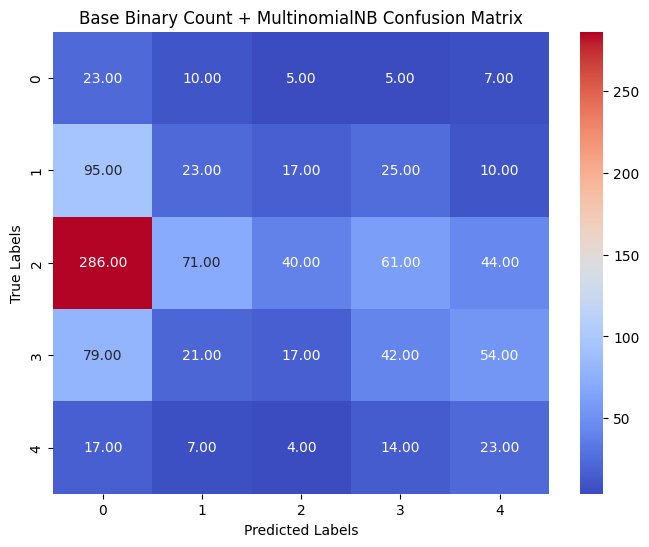


🔹 Base Count Stops + MultinomialNB Metrics:
✅ Best Parameters: {'vectorizer__max_features': 1000, 'classifier__alpha': 0.01}
🔹 Accuracy: 0.13
🔹 F1 Score: 0.15
🔹 Recall: 0.13
🔹 Precision: 0.32


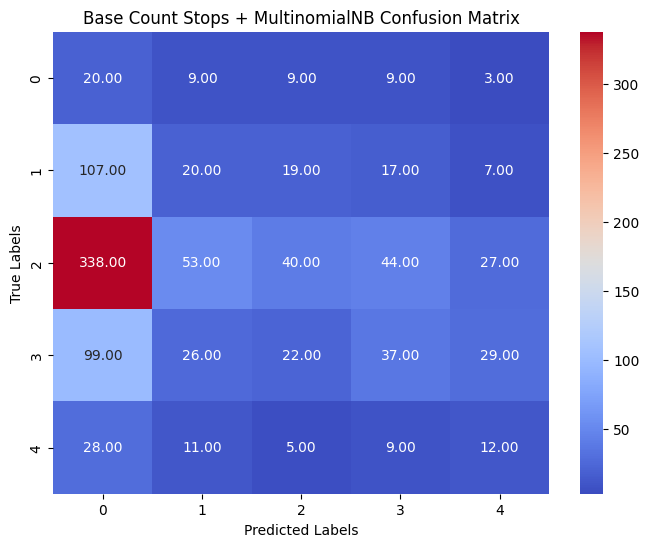


🔹 Base Custom Stops + MultinomialNB Metrics:
✅ Best Parameters: {'vectorizer__max_features': 1000, 'classifier__alpha': 0.01}
🔹 Accuracy: 0.12
🔹 F1 Score: 0.14
🔹 Recall: 0.12
🔹 Precision: 0.33


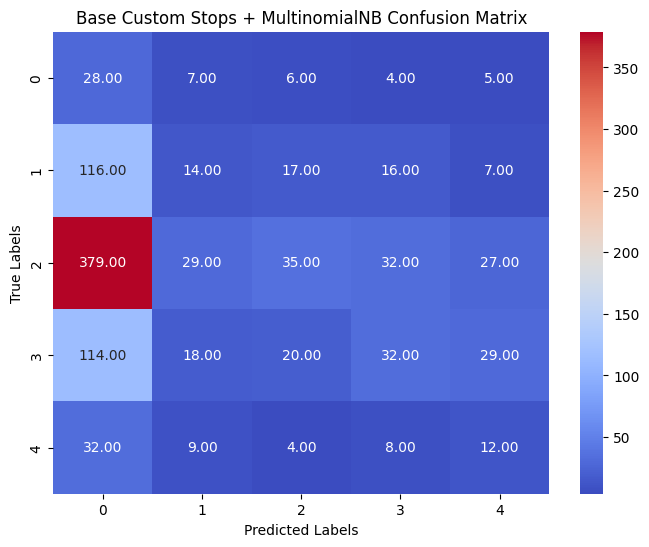


🔹 Base TF-IDF No Parms + MultinomialNB Metrics:
✅ Best Parameters: {'vectorizer__max_features': 4000, 'classifier__alpha': 0.25}
🔹 Accuracy: 0.16
🔹 F1 Score: 0.17
🔹 Recall: 0.16
🔹 Precision: 0.33


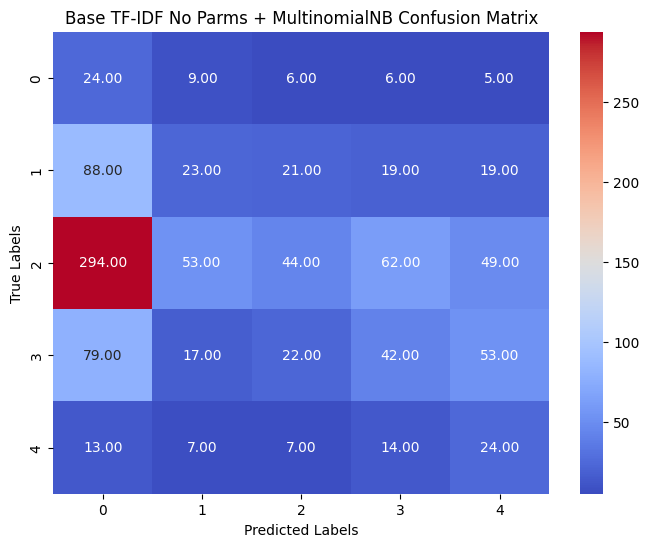


🔹 Base TF-IDF + MultinomialNB Metrics:
✅ Best Parameters: {'vectorizer__max_features': 750, 'classifier__alpha': 2.0}
🔹 Accuracy: 0.12
🔹 F1 Score: 0.13
🔹 Recall: 0.12
🔹 Precision: 0.31


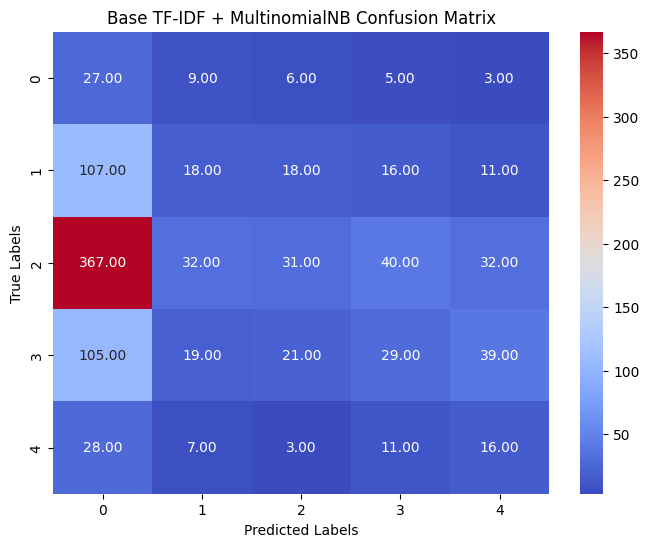


🔹 TF-IDF Sklearn Stops + MultinomialNB Metrics:
✅ Best Parameters: {'vectorizer__max_features': 3000, 'classifier__alpha': 1.5}
🔹 Accuracy: 0.12
🔹 F1 Score: 0.13
🔹 Recall: 0.12
🔹 Precision: 0.34


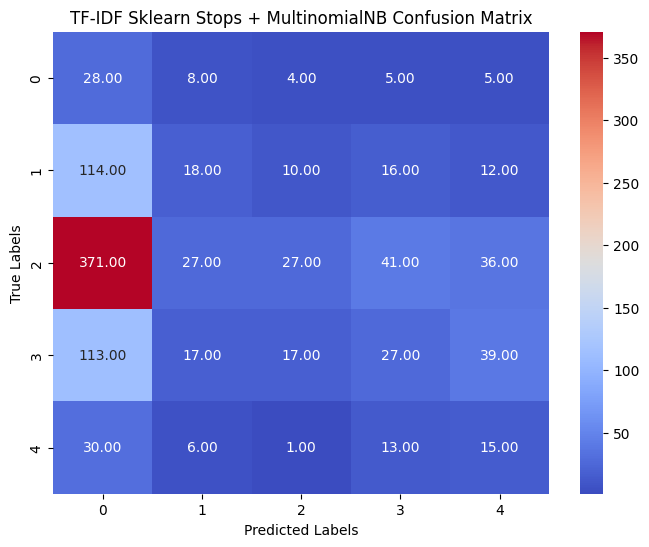


🔹 TF-IDF Custom Stops + MultinomialNB Metrics:
✅ Best Parameters: {'vectorizer__max_features': 1500, 'classifier__alpha': 1.0}
🔹 Accuracy: 0.12
🔹 F1 Score: 0.13
🔹 Recall: 0.12
🔹 Precision: 0.31


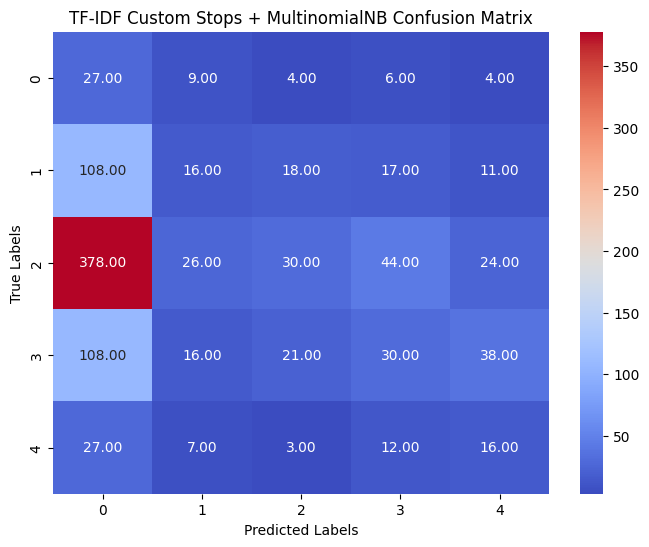


🔹 Base Binary Count + SVM Metrics:
✅ Best Parameters: {'vectorizer__max_features': 3000, 'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__class_weight': None, 'classifier__C': 1}
🔹 Accuracy: 0.46
🔹 F1 Score: 0.42
🔹 Recall: 0.46
🔹 Precision: 0.42


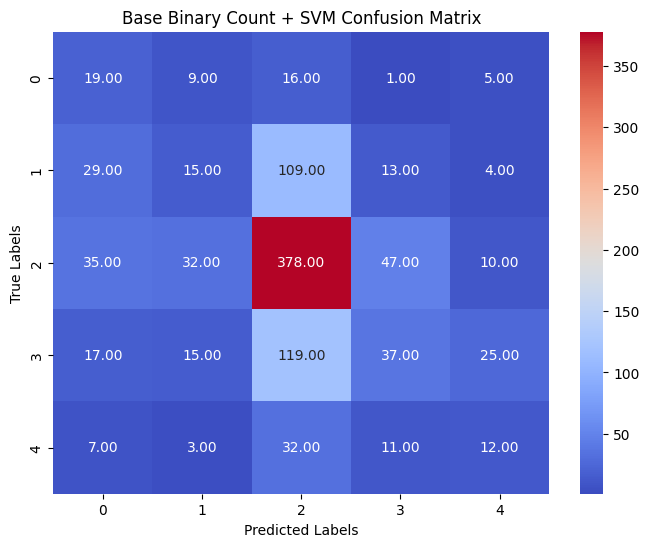


🔹 Base Count Stops + SVM Metrics:
✅ Best Parameters: {'vectorizer__max_features': 3000, 'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__class_weight': None, 'classifier__C': 1}
🔹 Accuracy: 0.47
🔹 F1 Score: 0.43
🔹 Recall: 0.47
🔹 Precision: 0.42


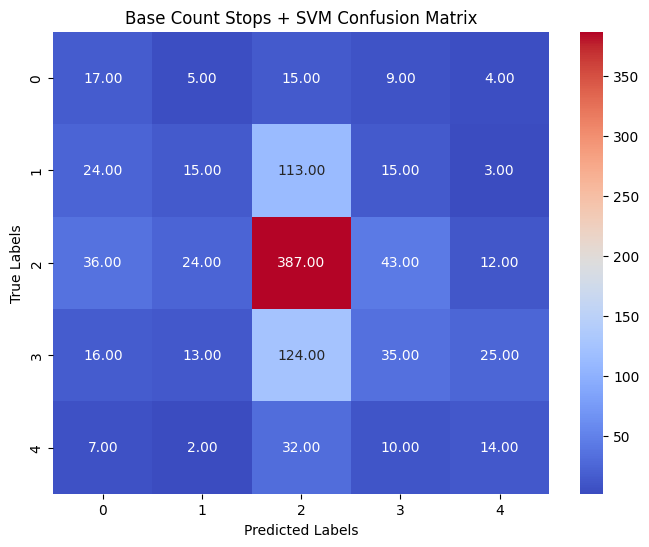


🔹 Base Custom Stops + SVM Metrics:
✅ Best Parameters: {'vectorizer__max_features': 750, 'classifier__kernel': 'linear', 'classifier__gamma': 'auto', 'classifier__class_weight': 'balanced', 'classifier__C': 1}
🔹 Accuracy: 0.47
🔹 F1 Score: 0.41
🔹 Recall: 0.47
🔹 Precision: 0.41


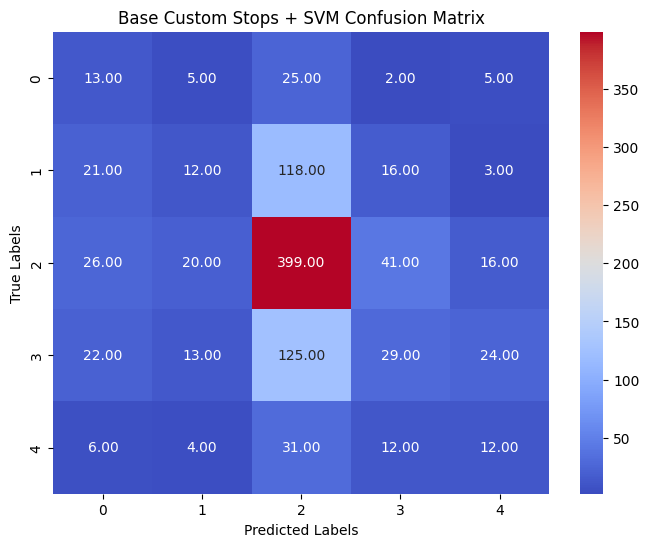


🔹 Base TF-IDF No Parms + SVM Metrics:
✅ Best Parameters: {'vectorizer__max_features': 3000, 'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__class_weight': None, 'classifier__C': 1}
🔹 Accuracy: 0.39
🔹 F1 Score: 0.40
🔹 Recall: 0.39
🔹 Precision: 0.42


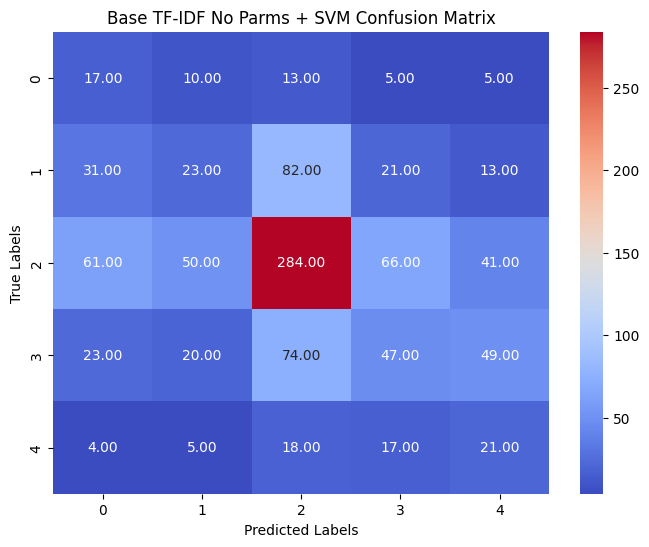


🔹 Base TF-IDF + SVM Metrics:
✅ Best Parameters: {'vectorizer__max_features': 1500, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__class_weight': None, 'classifier__C': 1}
🔹 Accuracy: 0.43
🔹 F1 Score: 0.41
🔹 Recall: 0.43
🔹 Precision: 0.42


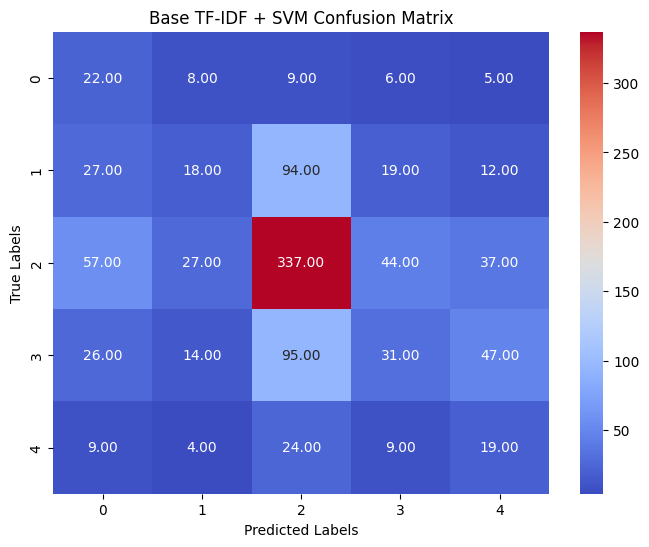


🔹 TF-IDF Sklearn Stops + SVM Metrics:
✅ Best Parameters: {'vectorizer__max_features': 1500, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__class_weight': None, 'classifier__C': 1}
🔹 Accuracy: 0.43
🔹 F1 Score: 0.41
🔹 Recall: 0.43
🔹 Precision: 0.43


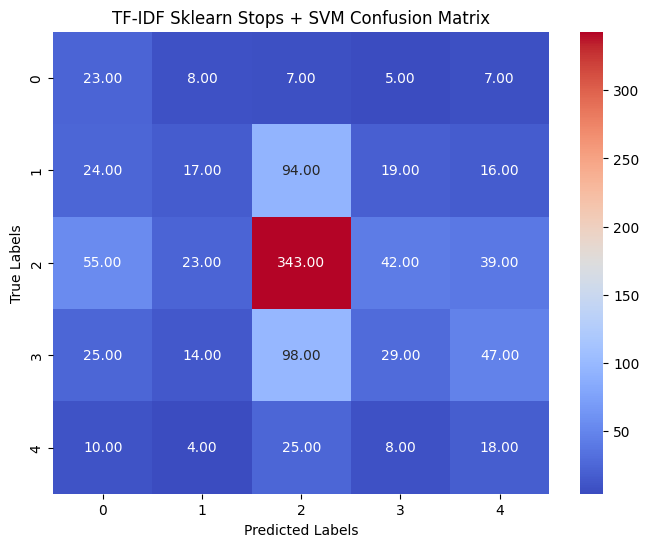


🔹 TF-IDF Custom Stops + SVM Metrics:
✅ Best Parameters: {'vectorizer__max_features': 750, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__class_weight': None, 'classifier__C': 10}
🔹 Accuracy: 0.44
🔹 F1 Score: 0.41
🔹 Recall: 0.44
🔹 Precision: 0.41


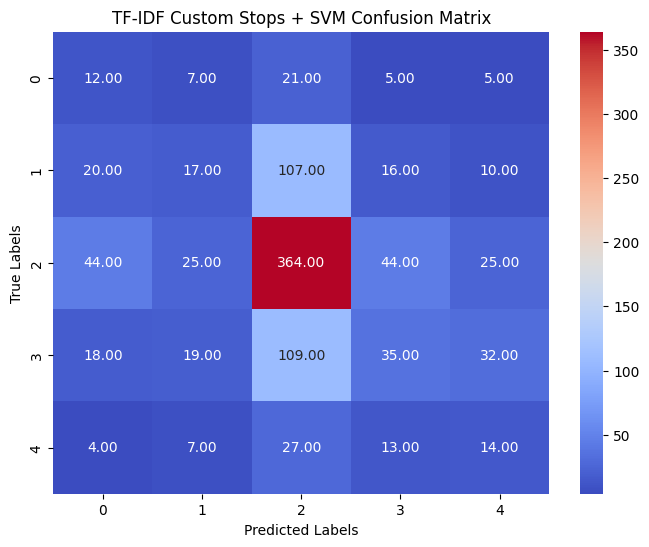

In [52]:
# Print best model parameters and evaluation metrics
for result in metrics:
    print(f"\n🔹 {result['Model']} Metrics:")
    print(f"✅ Best Parameters: {result['Best Params']}")
    print(f"🔹 Accuracy: {result['Accuracy']:.2f}")
    print(f"🔹 F1 Score: {result['F1 Score']:.2f}")
    print(f"🔹 Recall: {result['Recall']:.2f}")
    print(f"🔹 Precision: {result['Precision']:.2f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['Confusion Matrix'], annot=True, cmap="coolwarm", fmt=".2f",
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"{result['Model']} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [53]:
# Convert test results to DataFrame for visualization
metrics_results_df = pd.DataFrame(metrics)

# Display the metrics comparison
print("\nMetrics Comparison:")
print(metrics_results_df.iloc[:,:-1])


Metrics Comparison:
                                   Model  \
0      Base Binary Count + MultinomialNB   
1       Base Count Stops + MultinomialNB   
2      Base Custom Stops + MultinomialNB   
3   Base TF-IDF No Parms + MultinomialNB   
4            Base TF-IDF + MultinomialNB   
5   TF-IDF Sklearn Stops + MultinomialNB   
6    TF-IDF Custom Stops + MultinomialNB   
7                Base Binary Count + SVM   
8                 Base Count Stops + SVM   
9                Base Custom Stops + SVM   
10            Base TF-IDF No Parms + SVM   
11                     Base TF-IDF + SVM   
12            TF-IDF Sklearn Stops + SVM   
13             TF-IDF Custom Stops + SVM   

                                                                                                                                                   Best Params  \
0                                                                                                 {'vectorizer__max_features': 8000, 'classifier__alpha': 2.

Task 2:

In [54]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Train models with Randomized Search
rs_results2 = {}

for model_name, model_info in task2_models.items():
    classifier = model_info['classifier']
    param_grid = model_info['param_grid']  # still defined as a dict of lists
    for vec_name in model_info['vectorizers']:
        vectorizer = vectorizers[vec_name]  # Get corresponding vectorizer
        print(f"Training {model_name} with {vec_name}...")

        # Define pipeline with vectorizer and classifier
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])

        # Run Randomized Search
        random_search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grid,  # Note the change here!
            cv=cv,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1,
            n_iter=50,           # Number of parameter settings sampled
            random_state=42      # For reproducibility
        )
        random_search.fit(X_train, y_train)  # Use raw text input (vectorizer applied in pipeline)

        # Store the best results
        rs_results2[(vec_name, model_name)] = {
            'best_params': random_search.best_params_,
            'best_score': random_search.best_score_,
            'best_model': random_search.best_estimator_,
            'random_search': random_search  # Keeping full RandomizedSearchCV instance for later use
        }

Training MultinomialNB with Base N-Grams (2,3)...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training MultinomialNB with Base N-Grams (2,4)...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training MultinomialNB with TF-IDF N-Grams (2,3)...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training MultinomialNB with TF-IDF N-Grams (2,4)...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training SVM with Base N-Grams (2,3)...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training SVM with Base N-Grams (2,4)...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training SVM with TF-IDF N-Grams (2,3)...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Training SVM with TF-IDF N-Grams (2,4)...
Fitting 30 folds for each of 50 candidates, totalling 1500 fits


In [55]:
# Store test evaluation results
metrics2 = []

for (vec_name, model_name), result in rs_results2.items():
    best_model = result['best_model']

    # Transform test data using the best vectorizer inside the pipeline
    y_pred = best_model.predict(X_test)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # Store results
    metrics2.append({
        'Model': f"{vec_name} + {model_name}",
        'Best Params': result['best_params'],
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    })


🔹 Base N-Grams (2,3) + MultinomialNB Metrics:
✅ Best Parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 3000, 'classifier__alpha': 1.5}
🔹 Accuracy: 0.15
🔹 F1 Score: 0.17
🔹 Recall: 0.15
🔹 Precision: 0.34


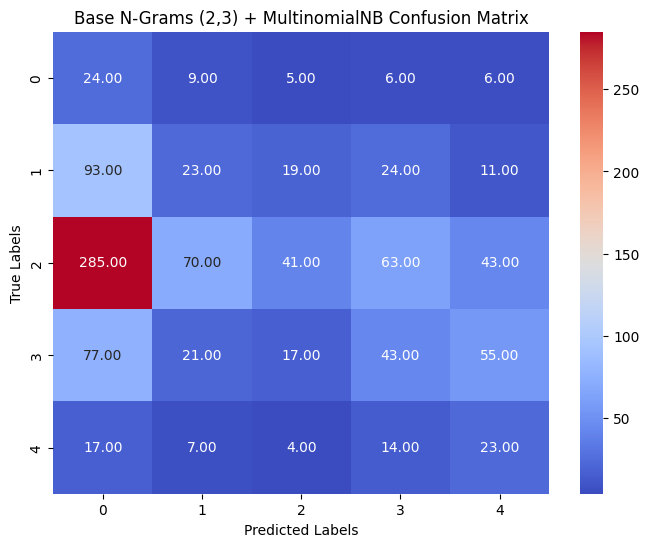


🔹 Base N-Grams (2,4) + MultinomialNB Metrics:
✅ Best Parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 3000, 'classifier__alpha': 1.5}
🔹 Accuracy: 0.15
🔹 F1 Score: 0.17
🔹 Recall: 0.15
🔹 Precision: 0.34


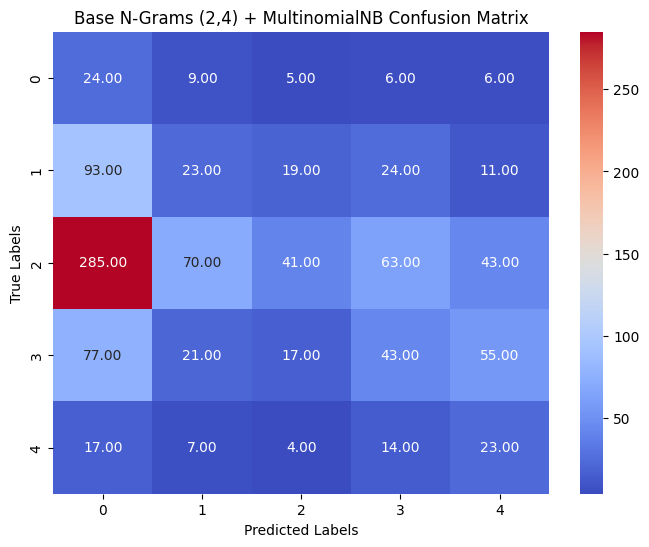


🔹 TF-IDF N-Grams (2,3) + MultinomialNB Metrics:
✅ Best Parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 750, 'classifier__alpha': 0.25}
🔹 Accuracy: 0.14
🔹 F1 Score: 0.15
🔹 Recall: 0.14
🔹 Precision: 0.33


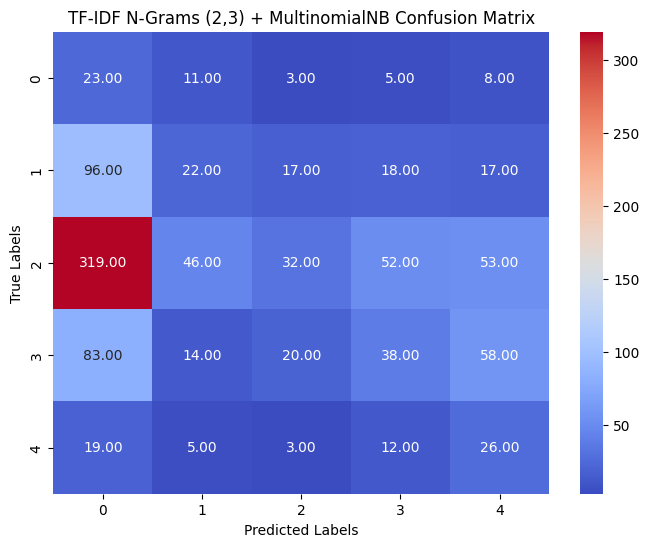


🔹 TF-IDF N-Grams (2,4) + MultinomialNB Metrics:
✅ Best Parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 750, 'classifier__alpha': 0.25}
🔹 Accuracy: 0.14
🔹 F1 Score: 0.15
🔹 Recall: 0.14
🔹 Precision: 0.33


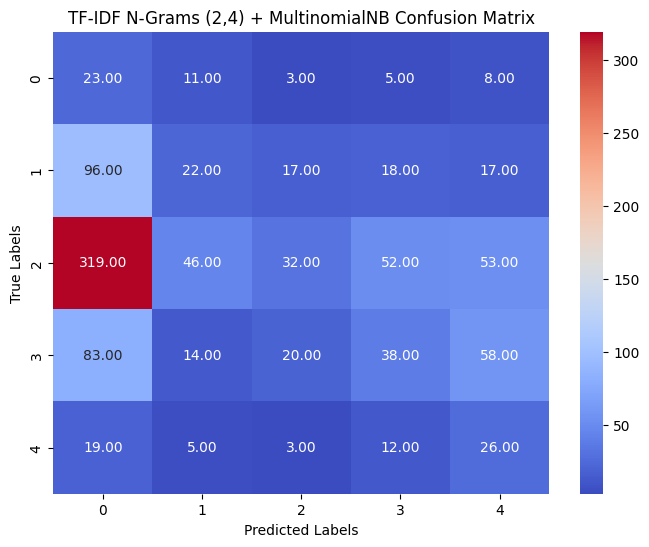


🔹 Base N-Grams (2,3) + SVM Metrics:
✅ Best Parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 1500, 'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__class_weight': None, 'classifier__C': 10}
🔹 Accuracy: 0.47
🔹 F1 Score: 0.43
🔹 Recall: 0.47
🔹 Precision: 0.43


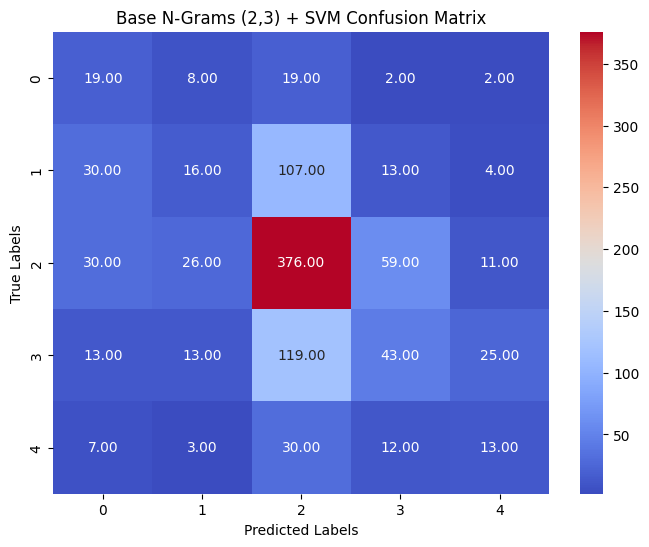


🔹 Base N-Grams (2,4) + SVM Metrics:
✅ Best Parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 1500, 'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__class_weight': None, 'classifier__C': 10}
🔹 Accuracy: 0.47
🔹 F1 Score: 0.43
🔹 Recall: 0.47
🔹 Precision: 0.43


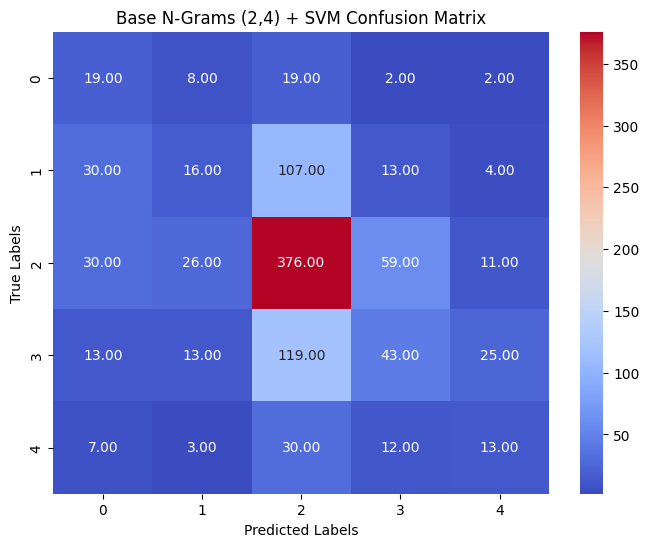


🔹 TF-IDF N-Grams (2,3) + SVM Metrics:
✅ Best Parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 3000, 'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__class_weight': 'balanced', 'classifier__C': 10}
🔹 Accuracy: 0.21
🔹 F1 Score: 0.19
🔹 Recall: 0.21
🔹 Precision: 0.31


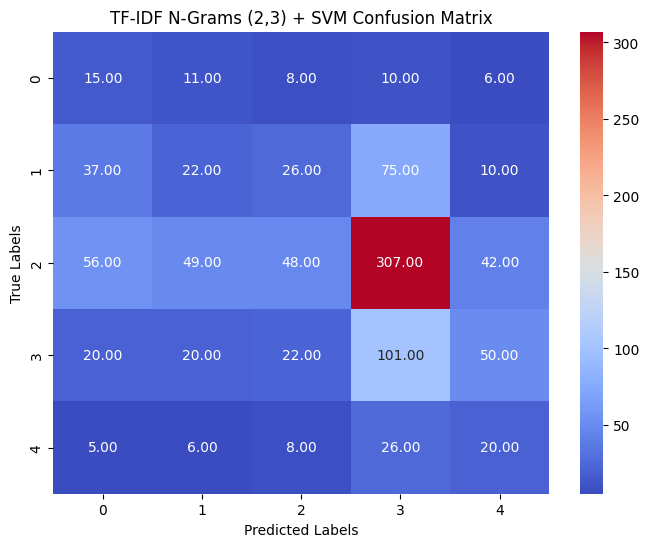


🔹 TF-IDF N-Grams (2,4) + SVM Metrics:
✅ Best Parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 3000, 'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__class_weight': 'balanced', 'classifier__C': 10}
🔹 Accuracy: 0.21
🔹 F1 Score: 0.19
🔹 Recall: 0.21
🔹 Precision: 0.31


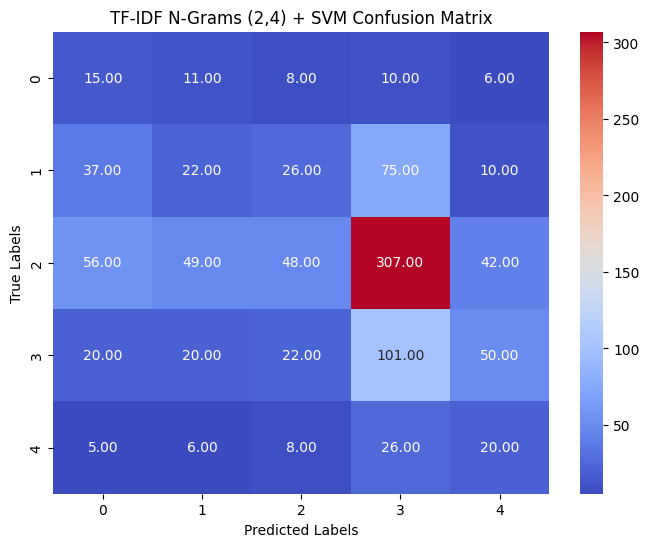

In [56]:
# Print best model parameters and evaluation metrics
for result in metrics2:
    print(f"\n🔹 {result['Model']} Metrics:")
    print(f"✅ Best Parameters: {result['Best Params']}")
    print(f"🔹 Accuracy: {result['Accuracy']:.2f}")
    print(f"🔹 F1 Score: {result['F1 Score']:.2f}")
    print(f"🔹 Recall: {result['Recall']:.2f}")
    print(f"🔹 Precision: {result['Precision']:.2f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['Confusion Matrix'], annot=True, cmap="coolwarm", fmt=".2f",
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"{result['Model']} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [57]:
# Convert test results to DataFrame for visualization
metrics_results_df2 = pd.DataFrame(metrics2)

# Display the metrics comparison
print("\nMetrics Comparison:")
print(metrics_results_df2.iloc[:,:-1])


Metrics Comparison:
                                  Model  \
0    Base N-Grams (2,3) + MultinomialNB   
1    Base N-Grams (2,4) + MultinomialNB   
2  TF-IDF N-Grams (2,3) + MultinomialNB   
3  TF-IDF N-Grams (2,4) + MultinomialNB   
4              Base N-Grams (2,3) + SVM   
5              Base N-Grams (2,4) + SVM   
6            TF-IDF N-Grams (2,3) + SVM   
7            TF-IDF N-Grams (2,4) + SVM   

                                                                                                                                                                                        Best Params  \
0                                                                                                   {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 3000, 'classifier__alpha': 1.5}   
1                                                                                                   {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 3000, 'classifier__alpha': 1.

Task 3:

In [58]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_sample['Lemmatized_Text'], df_sample['Sentiment'], random_state=42, stratify=df_sample['Sentiment'])

# Display the splits
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1875
Test set size: 625


In [59]:
# Create pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('svm', SVC())
])

In [60]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    'vectorizer__max_features': [100, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 8000],
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto'],
    'svm__class_weight': [None, 'balanced'],
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    n_iter=50,
    random_state=42
)

In [61]:
#Train the model using random search
random_search.fit(X_train, y_train)

Fitting 30 folds for each of 50 candidates, totalling 1500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=3, random_state=42),
                   estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                             ('svm', SVC())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'svm__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                                        'svm__class_weight': [None, 'balanced'],
                                        'svm__gamma': ['scale', 'auto'],
                                        'svm__kernel': ['linear', 'rbf',
                                                        'poly'],
                                        'vectorizer__max_features': [100, 250,
                                                                     500, 750,
                                                                     1000, 1500,
                                                                     2000, 3000,
                                                                     4000,
                                                                     8000]},
                   random_state=42, scoring='f1_weighted', verbose=1)

In [62]:
# Identify the best model
best_model = random_search.best_estimator_

# Use it to predict on the test set
y_pred = best_model.predict(X_test)

In [63]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

# Print out metrics
print(f"\n🔹 SVM Metrics:")
print(f"✅ Best Parameters: {random_search.best_params_}")
print(f"🔹 Accuracy: {accuracy:.2f}")
print(f"🔹 F1 Score: {f1:.2f}")
print(f"🔹 Recall: {recall:.2f}")
print(f"🔹 Precision: {precision:.2f}")


🔹 SVM Metrics:
✅ Best Parameters: {'vectorizer__max_features': 3000, 'svm__kernel': 'linear', 'svm__gamma': 'scale', 'svm__class_weight': None, 'svm__C': 1}
🔹 Accuracy: 0.54
🔹 F1 Score: 0.49
🔹 Recall: 0.54
🔹 Precision: 0.50


In [64]:
# Collect result in a list
results = []
results.append({
    'Model': 'SVM',
    'Best Params': random_search.best_params_,
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Recall': recall,
    'Precision': precision,
    'Confusion Matrix': confusion_matrix(y_test, y_pred)
})
df_metrics = pd.DataFrame(results)

# **Results:**

Based on the tasks identified, the SVM model using the complete training set performed the best, followed by the unigram SVM and the (2,3) bi/tri-gram SVM. These results seem a bit poor however upon verifying evaluation results from traditional methods on Kaggle, they seem to be aligned with the dataset (more complex models utilizing LLMs perform better, usually between 60-70%).

<Figure size 1400x600 with 0 Axes>

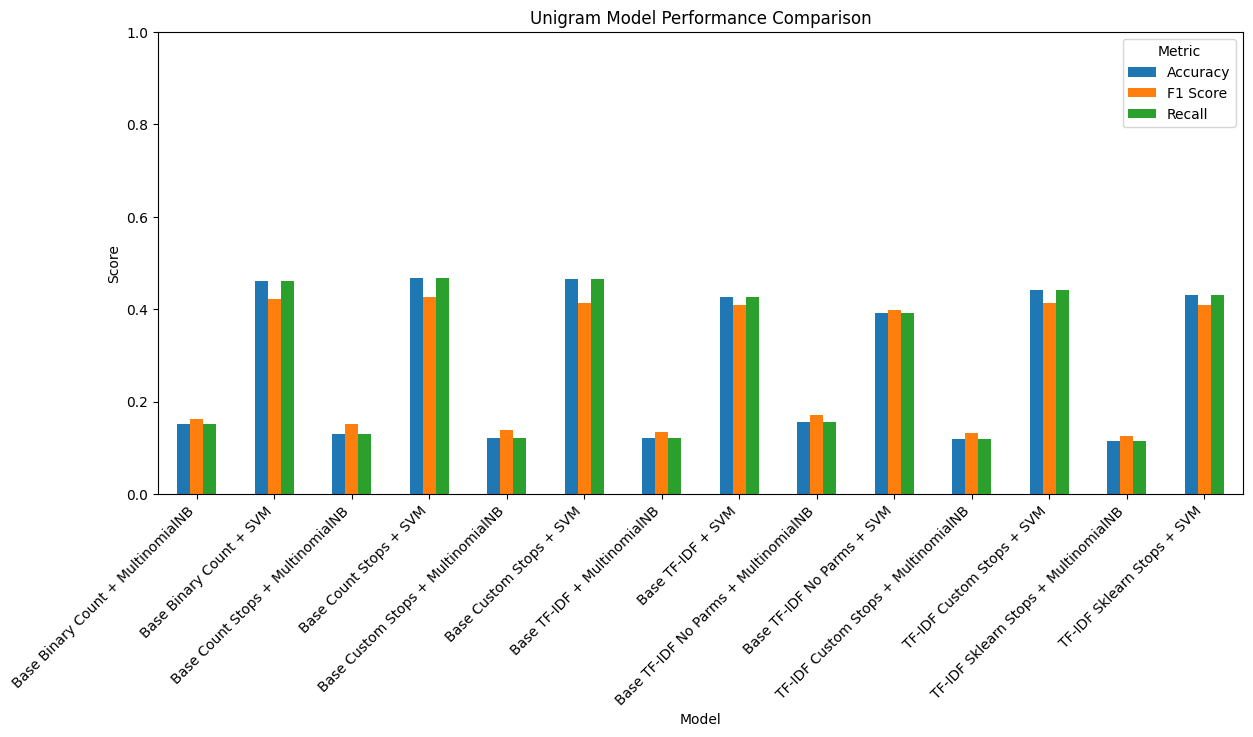

In [65]:
# Melt DataFrame for grouped bar plot
metrics_df = metrics_results_df.melt(id_vars=['Model'], value_vars=['Accuracy', 'F1 Score', 'Recall'],
                            var_name='Metric', value_name='Score')

# Plot comparison bar chart
plt.figure(figsize=(14, 6))
metrics_df.pivot(index='Model', columns='Metric', values='Score').plot(kind='bar', figsize=(14,6))
plt.title("Unigram Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Metric")
plt.ylim(0, 1)
plt.show()

<Figure size 1400x600 with 0 Axes>

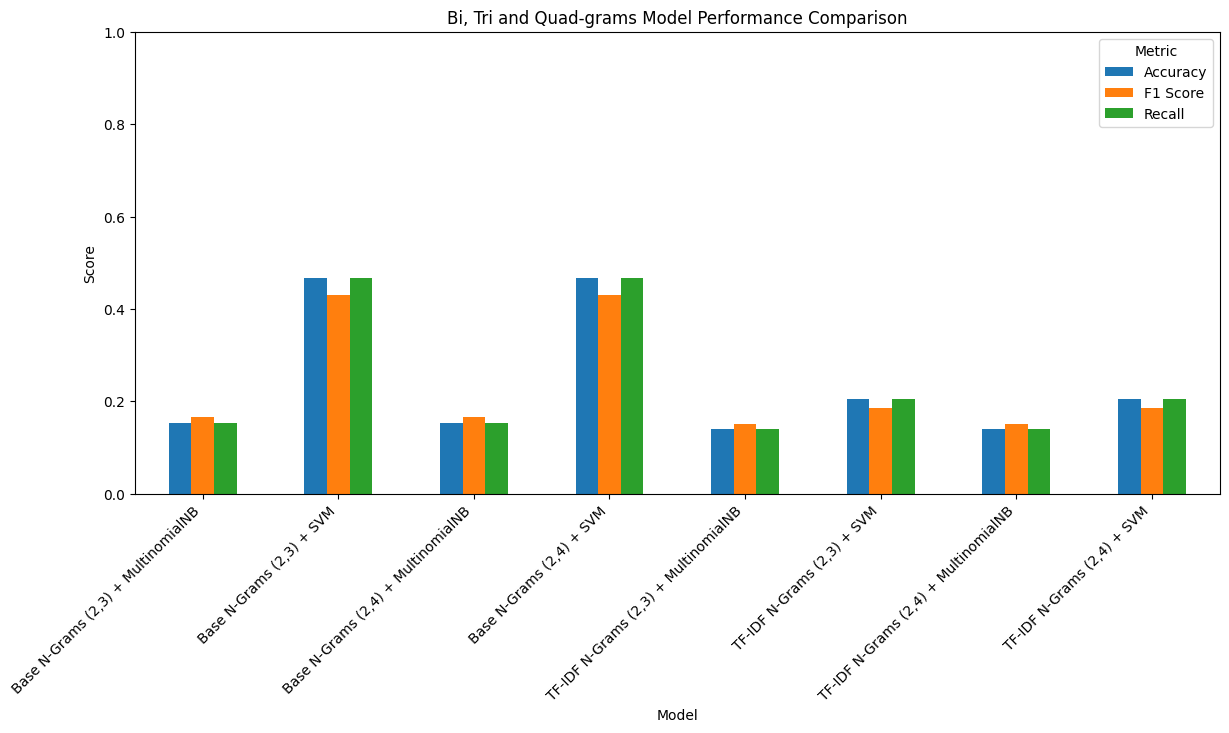

In [66]:
# Melt DataFrame for grouped bar plot
metrics_df2 = metrics_results_df2.melt(id_vars=['Model'], value_vars=['Accuracy', 'F1 Score', 'Recall'],
                            var_name='Metric', value_name='Score')

# Plot comparison bar chart
plt.figure(figsize=(14, 6))
metrics_df2.pivot(index='Model', columns='Metric', values='Score').plot(kind='bar', figsize=(14,6))
plt.title("Bi, Tri and Quad-grams Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Metric")
plt.ylim(0, 1)
plt.show()

In [67]:
metrics_df = df_metrics.melt(
    id_vars=['Model'],
    value_vars=['Accuracy', 'F1 Score', 'Recall'],
    var_name='Metric',
    value_name='Score'
)

<Figure size 1400x600 with 0 Axes>

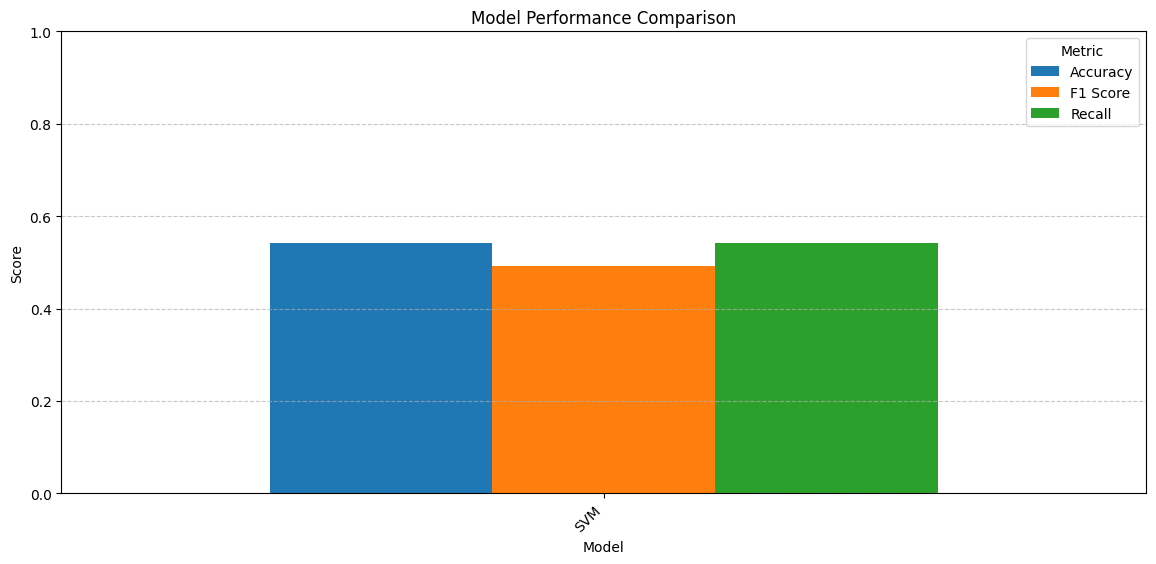

In [68]:
plt.figure(figsize=(14, 6))

# Pivot so each Metric gets its own bar for each Model
metrics_pivot = metrics_df.pivot(index='Model', columns='Metric', values='Score')
metrics_pivot.plot(kind='bar', figsize=(14,6), width=0.8)

plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Metric")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Conclusion:**

This dataset seems to be particularly difficult to accurately predict. After days of trying numerous parameters, models, imbalance techniques, etc.., the performance only marginally improved. Though I do think non-traditional methods would be a great application here, I do still think it would take great effort to get a model to perform around 75-80%, which is usually my baseline aim. Because the models for the assignment we constrained, I didn't use other models but I would definitely try some other algorithms like random forsts